# Data wrangling

## Contents
* [Data Collection](#data_collection)
* [Data Cleaning](#data_cleaning)
* [Data Definition](#data_definition)






In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import difflib


## Data Collection<a id='data_collection'></a>

In [428]:
anime_raw = pd.read_csv('data/anime.csv')
anime_raw.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [429]:
rating_raw = pd.read_csv('data/rating.csv')
rating_raw.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Data Cleaning<a id='data_cleaning'></a>

In [430]:
#Cleaning common steps:
#Check missing value
#Check duplicate value
#Check data type
#Check for extreme value

In [450]:
anime_df = anime_raw.copy()
anime_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [451]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [452]:
(anime_df== 'Unknown').any()

anime_id    False
name        False
genre       False
type        False
episodes     True
rating      False
members     False
dtype: bool

In [453]:
anime_df.loc[(anime_df['episodes'] == 'Unknown'), 'episodes'] = np.NaN
(anime_df== 'Unknown').any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating      False
members     False
dtype: bool

In [454]:
anime_df.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64

In [455]:
# Check datatype
print(anime_df.info())
anime_df['name'] = anime_df['name'].astype('string')
anime_df['type'] = anime_df['type'].astype('string')
anime_df['genre'] = anime_df['genre'].astype('string')
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
anime_df['rating'] = anime_df['rating'].astype('float')

print(anime_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  11954 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  string 
 2   genre     12232 non-null  string 
 3   type      12269 non-null  string 
 4   episodes  11954 non-null  float64
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float

In [456]:
# Check if anime that has genre null is from the same anime but different episode title or type. Check by finding if title has similarity to other animes. 
anime_has_null_genre = anime_raw[anime_raw['genre'].isnull()]
names_without_null_genre = anime_raw[~anime_raw['genre'].isnull()]['name']
names_has_null_genre = anime_has_null_genre['name']
anime_has_null_genre['matched_name'] = names_has_null_genre.apply(lambda x: difflib.get_close_matches(x, names_without_null_genre, n=1))
anime_has_null_genre

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_21221/1046459548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_has_null_genre['matched_name'] = names_has_null_genre.apply(lambda x: difflib.get_close_matches(x, names_without_null_genre, n=1))


,anime_id,name,genre,type,episodes,rating,members,matched_name
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604,[IS: Infinite Stratos 2]
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345,[]
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313,[Metropolis]
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242,[Match Uri no Shoujo]
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607,[Sakura Taisen: Katsudou Shashin]
...,...,...,...,...,...,...,...,...
11070,32032,Seikaisuru Kado,NaN,NaN,Unknown,NaN,1797,[]
11086,34310,Tamagotchi Movie: Tanpen Himitsu no Otodoke Da...,NaN,Movie,1,NaN,51,[]
11097,34474,Tsukipro The Animation,NaN,TV,Unknown,NaN,843,[Tsukiuta. The Animation]
11112,33035,Yuyushiki Special,NaN,Special,1,NaN,2294,[Shiki Specials]


In [457]:
# Fill the null genre with the matched anime's genre
df_has_null_genre = anime_has_null_genre.copy()
df_has_null_genre['matched_name'] = anime_has_null_genre['matched_name'].apply(lambda x: x[0] if len(x) > 0 else np.NaN)
df_has_null_genre['matched_genre'] = df_has_null_genre['matched_name'].apply(lambda x: anime_raw[anime_raw['name']==x]['genre'].values)
df_matched_genre = df_has_null_genre.copy()
df_matched_genre['matched_genre'] = df_has_null_genre['matched_genre'].apply(lambda x: x[0] if len(x) > 0 else np.NaN)
df_matched_genre

,anime_id,name,genre,type,episodes,rating,members,matched_name,matched_genre
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604,IS: Infinite Stratos 2,"Action, Comedy, Harem, Mecha, Sci-Fi"
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345,NaN,NaN
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313,Metropolis,"Adventure, Drama, Police, Romance, Sci-Fi, Sho..."
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242,Match Uri no Shoujo,"Drama, Kids"
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607,Sakura Taisen: Katsudou Shashin,"Adventure, Mecha, Sci-Fi, Shounen"
...,...,...,...,...,...,...,...,...,...
11070,32032,Seikaisuru Kado,NaN,NaN,Unknown,NaN,1797,NaN,NaN
11086,34310,Tamagotchi Movie: Tanpen Himitsu no Otodoke Da...,NaN,Movie,1,NaN,51,NaN,NaN
11097,34474,Tsukipro The Animation,NaN,TV,Unknown,NaN,843,Tsukiuta. The Animation,Music
11112,33035,Yuyushiki Special,NaN,Special,1,NaN,2294,Shiki Specials,"Horror, Mystery, Supernatural, Vampire"


In [458]:
# Apply the filled data to anime_df
print('genre null count before: ', anime_df['genre'].isna().sum())
df_matched_genre[['anime_id', 'matched_genre']]
anime_df['genre'].fillna(df_matched_genre['matched_genre'], inplace=True)
print('genre null count after: ', anime_df['genre'].isna().sum())

genre null count before:  62
genre null count after:  14


/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_21221/2974107618.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  anime_df['genre'].fillna(df_matched_genre['matched_genre'], inplace=True)


In [459]:
anime_df.isna().sum()

anime_id      0
name          0
genre        14
type         25
episodes    340
rating      230
members       0
dtype: int64

In [460]:
#Fill episodes for specific types
print('Missing episodes types:', anime_df[anime_df['episodes'].isna()]['type'].unique())

(anime_df[['type', 'episodes']].groupby('type').mean(), anime_df[['type', 'episodes']].groupby('type').median())

Missing episodes types: <StringArray>
['TV', 'Special', 'ONA', 'Music', 'Movie', 'OVA', <NA>]
Length: 7, dtype: string


(          episodes
 type              
 Movie     1.102389
 Music     1.131417
 ONA       6.877651
 OVA       2.417663
 Special   2.561341
 TV       35.915595,
          episodes
 type             
 Movie         1.0
 Music         1.0
 ONA           2.0
 OVA           2.0
 Special       1.0
 TV           24.0)

In [461]:
anime_df[['type', 'episodes']].groupby('type').std()

,episodes
type,
Movie,2.149296
Music,1.293852
ONA,11.382952
OVA,3.208938
Special,3.700094
TV,80.640355


Looks like  movie, music, ova and special has less than 5 std, and median is the rounded down of mean, so will replace the null episode value with the median value

In [462]:
anime_df.loc[(anime_df['type'] == 'Movie'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'Movie'), 'episodes'].fillna(value=1.0)
anime_df.loc[(anime_df['type'] == 'Music'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'Music'), 'episodes'].fillna(value=1.0)
anime_df.loc[(anime_df['type'] == 'OVA'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'OVA'), 'episodes'].fillna(value=2.0)
anime_df.loc[(anime_df['type'] == 'Special'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'Special'), 'episodes'].fillna(value=1.0)


In [463]:
anime_df.isna().sum()

anime_id      0
name          0
genre        14
type         25
episodes    280
rating      230
members       0
dtype: int64

In [464]:
anime_df[anime_df['type'].isna()]

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",<NA>,NaN,NaN,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",<NA>,NaN,NaN,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",<NA>,NaN,NaN,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",<NA>,NaN,NaN,22133
10918,33845,Free! (Shinsaku),"School, Sports",<NA>,NaN,NaN,8666
10949,33475,Busou Shoujo Machiavellianism,"Action, School, Shounen",<NA>,NaN,NaN,1896
10963,31456,Code:Realize: Sousei no Himegimi,"Adventure, Fantasy, Romance, Shoujo",<NA>,NaN,NaN,4017
10983,34332,Flying Babies,"Comedy, Magic, Shounen, Slice of Life, Superna...",<NA>,NaN,NaN,22
10988,34280,Gamers!,"Comedy, Romance, School",<NA>,NaN,NaN,1045
10990,34485,Ganko-chan,Comedy,<NA>,NaN,NaN,11


Seems like when type is null, episodes and ratings are null as well. And we have 230 records that's missing the rating. One idea is that we can fill the rating value by fuzzing matching with same anime but different episode or type, like what we did for genre. However, while it's more likely the genre would stay the same if same anime, the rating could vary depend on the season, episode or type. Thus, we will not fill the rating values.

With out the rating data, it would be useless for Content Based Filtering, but could be useful for Collaborative Filtering. Thus, we will create 2 dataset. One without any null metadata values; another without any null rating values.

Before we split the dataset, let's check a few other things

In [465]:
# Check duplicates
anime_df[['name', 'type']].duplicated().any()

False

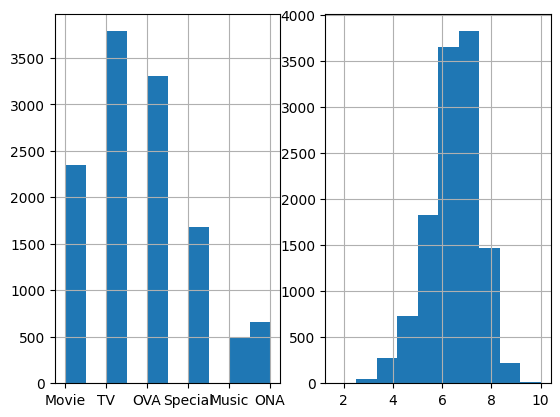

In [466]:
# Check feature outliers
fig, (ax1, ax2) = plt.subplots(1, 2)
anime_df['type'].hist(ax = ax1)
anime_df['rating'].hist(ax = ax2, bins=10)
plt.show()

In [467]:
anime_df[['rating', 'members']].describe()

,rating,members
count,12064.000000,1.229400e+04
mean,6.473902,1.807134e+04
std,1.026746,5.482068e+04
min,1.670000,5.000000e+00
25%,5.880000,2.250000e+02
50%,6.570000,1.550000e+03
75%,7.180000,9.437000e+03
max,10.000000,1.013917e+06


Ok. We checked for fillable missing data, potential duplicates, feature value outliers, and the datatype. Now let's split the dataset into two. One without any null metadata values; another without any null rating values.

In [468]:
anime_df_no_null_rating = anime_df[~anime_df['rating'].isna()]
anime_df_no_null_rating.isna().sum()

anime_id      0
name          0
genre         9
type          0
episodes    143
rating        0
members       0
dtype: int64

In [469]:
anime_df_no_null_metadata = anime_df[(~anime_df['genre'].isna()) & (~anime_df['type'].isna())]
anime_df_no_null_metadata.isna().sum()

anime_id      0
name          0
genre         0
type          0
episodes    252
rating      201
members       0
dtype: int64

In [490]:
#Cleaning for rating
rating_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [491]:
rating_raw.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [492]:
rating_raw[rating_raw.duplicated(keep=False)]

,user_id,anime_id,rating
4499258,42653,16498,8
4499316,42653,16498,8


In [494]:
print(rating_raw.duplicated(keep=False).sum())
rating_df = rating_raw.drop_duplicates()
print(rating_df.duplicated(keep=False).sum())

2
0


## Data Definition<a id='data_definition'></a>

In [ ]:
# save data
anime_df_no_null_rating.to_csv('data/anime_df_no_null_rating.csv', sep=',')
anime_df_no_null_metadata.to_csv('data/anime_df_no_null_metadata.csv', sep=',')
rating_df.to_csv('data/rating_df.csv', sep=',')
